In [1]:
# This notebook runs preparation for SeismicGeometry tests and SeismicGeometry tests for different cube formats
%load_ext autoreload
%autoreload 2
import os
import sys
from datetime import date

import glob
import json
import nbformat
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

sys.path.append('../..')
from seismiqb.batchflow.utils_notebook import run_notebook

In [2]:
DATESTAMP = date.today().strftime("%Y-%m-%d")

# Constants and parameters:
TEST_FOLDER = './geometry_test_files/'
CUBE_NAME = f'test_cube_{DATESTAMP}.sgy'
FORMATS = ['sgy', 'hdf5', 'qhdf5', 'blosc', 'qblosc']

# Storage preparation:
# The `tmp` dir contains cube files: cube in different formats and meta
# The `notebooks` dir contains notebooks results (notebooks copies with outputs)
!rm -rf {TEST_FOLDER + 'tmp/'}
!rm -rf {TEST_FOLDER + 'notebooks/'}
!mkdir {TEST_FOLDER + 'tmp/'}
!mkdir {TEST_FOLDER + 'notebooks/'}

# if previous run failed than we need to delete corresponding timings
failed_timings_file = glob.glob(TEST_FOLDER + 'timings*fail*.json')

if failed_timings_file:
    os.remove(failed_timings_file[0])

DROP_EXTRA_FILES = True # drop files reffering to successful tests
SHOW_TEST_ERROR_INFO = True # whether to show info about a test case with an error (if an error exists)

msg = DATESTAMP + '\n\n'

In [3]:
# Run the notebook with preparation for tests.
# It contains: data creation, data loading checking and cube conversion into different formats
out_path_ipynb = TEST_FOLDER+f'notebooks/geometry_test_preparation_out_{DATESTAMP}.ipynb'

exec_info = run_notebook(
    path='./geometry_test_preparation.ipynb',
    nb_kwargs={
        'CUBE_NAME': CUBE_NAME,
        'TEST_FOLDER': TEST_FOLDER,
        'CUBE_SHAPE': (1000, 200, 400),
        'SEED': 42,
        'DATESTAMP': DATESTAMP
    },
    out_path_ipynb=out_path_ipynb,
    display_links=False
)

if exec_info==True:
    msg += 'Data was successfully prepared.\n'
else:
    msg += f'An ERROR occured in cell number {exec_info}:\n{out_path_ipynb}\n'

print(msg)

2021-09-28

Data was successfully prepared.



In [4]:
# Run the test notebook for the cube in each data format.
# It contains: checking data; attributes, slides, crops loading test, data loading timings and visualization tests.
timings = {}
all_OK = True

for f in tqdm(FORMATS):
    current_message = ''

    # Run and save the test notebook
    out_path_ipynb = TEST_FOLDER + f'notebooks/geometry_test_data_format_{f.upper()}_out_{DATESTAMP}.ipynb'

    exec_info = run_notebook(
        path='./geometry_test_data_format.ipynb',
        nb_kwargs={
            'CUBE_NAME': CUBE_NAME.replace('sgy', f),
            'TEST_FOLDER': TEST_FOLDER,
            'N_SLIDE': 1000,
            'N_CROP': 300,
            'FIGSIZE': (12, 6),
            'SEED': 42,
            'DATESTAMP': DATESTAMP
        },
        insert_pos=1, 
        out_path_ipynb=out_path_ipynb,
        display_links=False
    )
    
    # Saving logs
    if exec_info==True:
        with open(TEST_FOLDER + f'tmp/timings_{f}_{DATESTAMP}.json', "r") as infile:
            timings.update(json.load(infile))

        # If everything is OK we can delete the test notebook
        if DROP_EXTRA_FILES:
            os.remove(out_path_ipynb)

        current_message += f'Notebook for {f.upper()} executed correctly and was deleted.\n'
    else:
        all_OK = False
        current_message += f'An ERROR occured in cell number {exec_info}:\n'

        if SHOW_TEST_ERROR_INFO:
            # Get first line in the error cell. It contains comment with test case.
            out_notebook = nbformat.read(out_path_ipynb, as_version=4)
            first_line = out_notebook['cells'][exec_info + 1]['source'].split('\n')[0]
            # plus one because we inserted additional cell

            if first_line[0]=='#':
                # Prettifyings:
                if first_line[-1]==':':
                    first_line = first_line[1:-1]
                else:
                    first_line = first_line[1:]

                current_message += f'Test \"{first_line.strip()}\" failure in:\n'

        current_message += f'{out_path_ipynb}'

    print(current_message)
    msg += current_message

  0%|          | 0/5 [00:00<?, ?it/s]

Notebook for SGY executed correctly and was deleted.

Notebook for HDF5 executed correctly and was deleted.

Notebook for QHDF5 executed correctly and was deleted.

Notebook for BLOSC executed correctly and was deleted.

Notebook for QBLOSC executed correctly and was deleted.



In [5]:
print(msg) # check representation for log

2021-09-28

Data was successfully prepared.
Notebook for SGY executed correctly and was deleted.
Notebook for HDF5 executed correctly and was deleted.
Notebook for QHDF5 executed correctly and was deleted.
Notebook for BLOSC executed correctly and was deleted.
Notebook for QBLOSC executed correctly and was deleted.



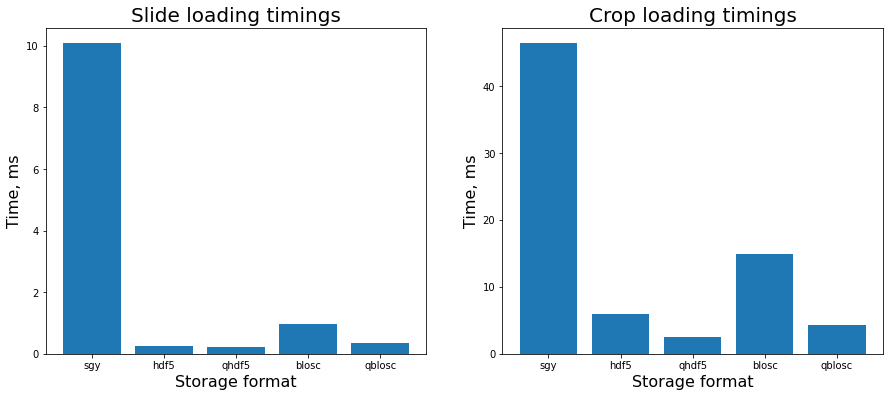

In [6]:
# Visualize timings
def plot_ax(dct, unit, title, ax):
    bars = ax.bar(dct.keys(), dct.values())
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Storage format', fontsize=16)
    ax.set_ylabel(unit, fontsize=16)
    return ax

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0] = plot_ax({key: value['slide']['wall'] for key, value in timings.items()},
                 "Time, ms", "Slide loading timings", axs[0])
axs[1] = plot_ax({key: value['crop']['wall'] for key, value in timings.items()},
                 "Time, ms", "Crop loading timings", axs[1])
plt.show()

In [7]:
# Dump timings and remove extra files
if all_OK:
    timings['state'] = 'OK'

    if DROP_EXTRA_FILES:
        timings_file = glob.glob(TEST_FOLDER + 'timings*.json')[0]
        os.remove(timings_file)

        !rm -rf {TEST_FOLDER + 'tmp/'}
        !rm -rf {TEST_FOLDER + 'notebooks/'}
        
    with open(TEST_FOLDER + f'timings_{DATESTAMP}.json', "w") as outfile:
        json.dump(timings, outfile)
else:
    timings['state'] = 'FAIL'

    if DROP_EXTRA_FILES:
        timings_files = glob.glob(TEST_FOLDER + 'tmp/timings*')
        for file_name in timings_files:
            os.remove(TEST_FOLDER + 'tmp/' + file_name)
            
    with open(TEST_FOLDER + f'timings_fail_{DATESTAMP}.json', "w") as outfile:
        json.dump(timings, outfile)